Let's do some Deep Learning!
-----

<center><img src="images/deep_learning.png" width="1000"/></center>

----
Apply word2vec to a dataset
-----

Overview:

1. Download some training data
1. Setup word2vec model in TensorFlow
1. Train on the data
1. Visualize the result

This notebook is based on a [TensorFlow tutorial for word2vec](https://github.com/tensorflow/tensorflow/edit/r1.4/tensorflow/examples/tutorials/word2vec/word2vec_basic.py).

In [1]:
reset -fs

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import collections
import math
import os
from pprint import pprint
import random
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.manifold import TSNE

%matplotlib inline  

----
Step 1: Download the data.
----

In [4]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
    
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    
    return filename

filename = maybe_download('text8.zip', 31_344_016)

Found and verified text8.zip


☝️ While this code is running, preview the code ahead.

In [19]:
# Read the data into a list of strings.
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data(filename)
print('Dataset size: {:,} words'.format(len(vocabulary)))

Dataset size: 17,005,207 words


In [20]:
# Let's have a peek at the head
vocab_head = " ".join(vocabulary[:20])
print(vocab_head)

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english


Notice: None of the words are capitalized and there is no punctuation.

Preprocessing is an art. It depends on your raw data and how you plan to use your final data. You might want to encode ngrams, instead of just splitting all items into unigrams.

-----
Step 2: Build the dictionary 
-----

In [21]:
vocabulary_size = 50_000

def build_dataset(words, n_words):
    """Process raw inputs into a dataset."""
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [22]:
data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)

Variable Legend
------
data - list of codes (integers from 0 to vocabulary_size-1).   
    This is the original text but words are replaced by their codes

count - map of words(strings) to count of occurrences

dictionary - map of words(strings) to their codes(integers)

reverse_dictionary - maps codes(integers) to words(strings)

In [23]:
del vocabulary # Reduce memory by getting rid of the "heavy" list of strings

In [24]:
data[:5] # An index of each word (as it appears in order) to its rank. Therefore we don't have reference the string

[5234, 3081, 12, 6, 195]

In [25]:
dictionary['the'] # word: rank

1

In [26]:
reverse_dictionary[42] # rank: word

'but'

In [27]:
print('Most common words:') 
print(*count[:5], sep="\n")

Most common words:
['UNK', 418391]
('the', 1061396)
('of', 593677)
('and', 416629)
('one', 411764)


In [28]:
print('Most least words:')
print(*count[-5:], sep="\n")

Most least words:
('codeword', 9)
('senussi', 9)
('unscr', 9)
('leonards', 9)
('hif', 9)


----
Step 3: Function to generate a training batch for the skip-gram model.
-----

In [29]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

In [30]:
batch, labels = generate_batch(batch_size=8, 
                               num_skips=2, 
                               skip_window=1)

In [31]:
print(vocab_head)

anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english


In [32]:
# Example of self-supervised
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 5234 anarchism
3081 originated -> 12 as
12 as -> 6 a
12 as -> 3081 originated
6 a -> 12 as
6 a -> 195 term
195 term -> 2 of
195 term -> 6 a


----
Step 4: Build and train a skip-gram model.
-----

In [33]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.
num_sampled = 64      # Number of negative examples to sample.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In [34]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Compute the average NCE loss for the batch.
        # tf.nce_loss automatically draws a new sample of the negative labels each
        # time we evaluate the loss.
        # Explanation of the meaning of NCE loss:
        #   http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
        loss = tf.reduce_mean(
          tf.nn.nce_loss(weights=nce_weights,
                         biases=nce_biases,
                         labels=train_labels,
                         inputs=embed,
                         num_sampled=num_sampled,
                         num_classes=vocabulary_size))

        # Construct the SGD optimizer using a learning rate of 1.0.
        optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

        # Compute the cosine similarity between minibatch examples and all embeddings.
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(
          normalized_embeddings, valid_dataset)
        similarity = tf.matmul(
          valid_embeddings, normalized_embeddings, transpose_b=True)

        # Add variable initializer.
        init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


----
Step 5: Begin training.
-----

In [35]:
num_steps = 2_001 #1 #2_001 #100_001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2_000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 2_000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to '%s':" % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
                print()
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  294.25823974609375
Nearest to 'war': fishery, appalling, instructs, syllabic, quest, skew, diminution, anonymous,
Nearest to 'th': discontinuities, eyesight, homotopy, takashi, coltrane, guitars, offices, toasting,
Nearest to 'two': epilepsy, implausible, celebrations, unaccompanied, contemporaneous, stolen, unaccustomed, tempe,
Nearest to 'b': clocked, assays, infidels, locksmiths, humorously, farmland, rulebook, bledsoe,
Nearest to 'into': chrono, cliffordadams, testimonium, tes, typing, associates, johnny, regular,
Nearest to 'they': hillside, kilns, alton, resembles, donelson, landform, hostel, assassinations,
Nearest to 'so': ves, first, jana, ribbons, ivb, billed, spit, successes,
Nearest to 'nine': garments, ole, blurred, cerevisiae, tld, donations, unpredictable, straddling,
Nearest to 'these': bannerman, pediatric, derg, tellers, zen, alembert, emphasise, intangible,
Nearest to 'may': cited, innovations, valeria, tried, patchy, ejective, 

<center><img src="images/watiing.jpg" width="700"/></center>

-----
Step 6: Visualize the embeddings.
----

We'll use t-sne.

[t-sne](https://lvdmaaten.github.io/tsne/) is a cool way to visualize of high-dimensional datasets by reducing the number dimensions.

In [ ]:
tsne = TSNE(perplexity=30, 
            n_components=2, 
            init='pca', 
            n_iter=5_000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]

n_words_to_visualize = 40

for i, label in enumerate(labels[:n_words_to_visualize]):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

----
Reflective Questions
----

What do you see?

How would you describe the relationships?

------

Let's render and save more samples.

In [37]:
def plot_with_labels(low_dim_embs, labels, filename='images/tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)

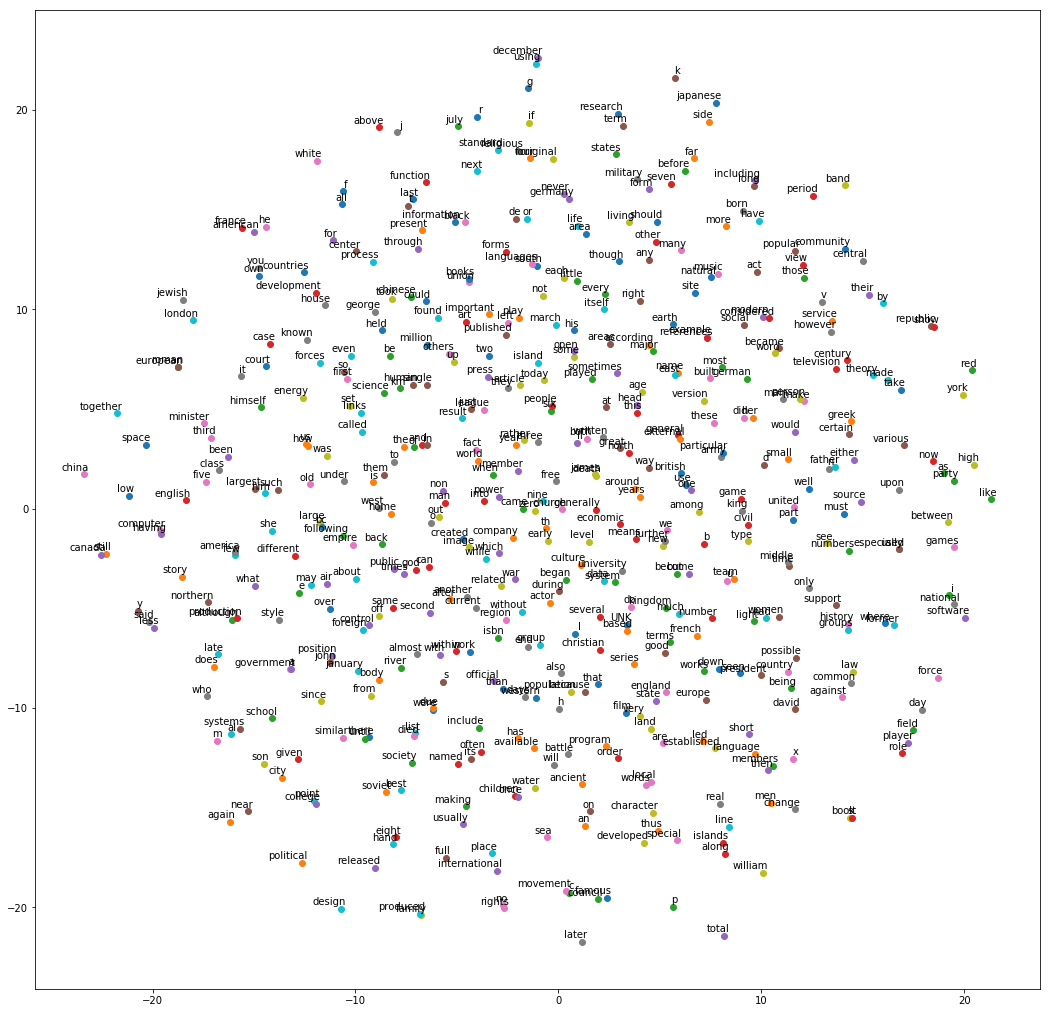

In [38]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

Check out a better version: [Embedding projector](http://projector.tensorflow.org/)

<br>
<br> 
<br>

----